In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
from datasets import load_dataset_builder, load_dataset
from transformers import DataCollatorForSeq2Seq
import evaluate
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer

import torch
import platform

print(platform.platform())
print(torch.has_mps)

macOS-14.1-arm64-arm-64bit
True


/var/folders/sm/hcy50x855gvf2b1qwkjstnvh0000gn/T/ipykernel_40769/878238529.py:14: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  print(torch.has_mps)


**REFs:**
- https://huggingface.co/docs/transformers/tasks/summarization

In [2]:
import os
dataset_name = 'reddit'
model = 'T5'
generation = 'Gen0'
output_dir=os.path.join(dataset_name, model, generation)
output_dir

'reddit/T5/Gen0'

In [2]:
tifu = load_dataset("reddit_tifu", 'long')

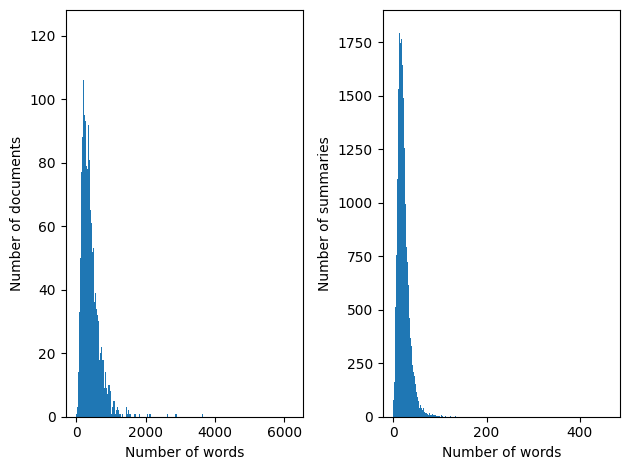

In [3]:
# tifu = tifu.add_column
doc_sent_len = [len(re.findall(r'\w+', sentence)) for sentence in tifu['train']['documents']]
summ_sent_len = [len(re.findall(r'\w+', sentence)) for sentence in tifu['train']['tldr']]

fig, axs = plt.subplots(1, 2, tight_layout=True)

axs[0].hist(doc_sent_len, bins=max(doc_sent_len));
axs[0].set_xlabel('Number of words')
axs[0].set_ylabel('Number of documents')
axs[1].hist(summ_sent_len, bins=max(summ_sent_len));
axs[1].set_xlabel('Number of words')
axs[1].set_ylabel('Number of summaries');

In [4]:
# tifu.train_test_split(test_size=0.1)
dataset = tifu['train'].train_test_split(test_size=0.2)
dataset

DatasetDict({
    train: Dataset({
        features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
        num_rows: 33711
    })
    test: Dataset({
        features: ['ups', 'num_comments', 'upvote_ratio', 'score', 'documents', 'tldr', 'title'],
        num_rows: 8428
    })
})

In [5]:
def show_samples(dataset, num_samples=3, seed=42):
    sample = dataset["train"].shuffle(seed=seed).select(range(num_samples))
    for example in sample:
        title, doc, summ = example['title'], example['documents'], example['tldr']
        print(f">> title: {title}")
        print(">> documents: {0}...".format(doc[:doc.find('\n')]))
        print(f">> summary: {summ}\n")

show_samples(dataset, 3)

>> title: thinking my boss wanted to hook up with me.
>> documents: throwaway for obvious reasons. keeping it short since the title is the  ...
>> summary: version.

>> title: singing my way by frank sinatra
>> documents: this story takes place about a week ago and i only now can laugh about it enough to post about it. ...
>> summary: lost some clients by taking some 7-11 boner pills, got laughed out of a midget boxing match and got roughed up by ladyboys for singing a taboo karaoke song

>> title: steaming my clothes
>> documents: though technically occurring last night, i'm still dealing with the aftermath....
>> summary: steamed shirts in hotel shower. fell asleep.



In [6]:
sum([sent > 512 for sent in summ_sent_len])

0

In [7]:
from transformers import AutoTokenizer

model_checkpoint = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/Users/madisonthantu/Desktop/COMS 6998/Final Project/recursive_LLMs/langgen/lib/python3.10/site-packages/transformers/models/t5/tokenization_t5_fast.py:158: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [8]:
prefix = "summarize: "

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["documents"]]
    model_inputs = tokenizer(inputs, max_length=1024, truncation=True)

    labels = tokenizer(text_target=examples["tldr"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [9]:
tokenized_tifu = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/33711 [00:00<?, ? examples/s]

Map:   0%|          | 0/8428 [00:00<?, ? examples/s]

In [10]:
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_checkpoint)

In [11]:
rouge = evaluate.load("rouge")

In [12]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    result = rouge.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)

    return {k: round(v, 4) for k, v in result.items()}

In [13]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [14]:
device = torch.device('mps')
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

In [18]:
training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    push_to_hub=True,
)

In [16]:
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_tifu["train"],
    eval_dataset=tokenized_tifu["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

  0%|          | 0/8428 [00:00<?, ?it/s]

You're using a T5TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


RuntimeError: MPS backend out of memory (MPS allocated: 16.17 GB, other allocations: 1.23 GB, max allowed: 18.13 GB). Tried to allocate 768.00 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

: 